In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras import applications
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img,array_to_img
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input
from keras import backend as K
K.set_image_dim_ordering('th')

import progressbar

import os

from IPython.display import Image, display, clear_output

Using TensorFlow backend.


In [2]:
os.chdir("/home/dwx/Documents/Studium/DTU/11/DL Deep Learning/project/ISIC_MSK-2_1_sorted")

In [4]:
# dimensions of our images.
img_width, img_height = 150, 150
top_model_weights_path = 'bottleneck_fc_model_jk.h5'
train_data_dir = PATH+'train/'
validation_data_dir =PATH+ 'validation/'
test_dir =PATH+ 'test/'


In [5]:
def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1. / 255,
                                 rotation_range=360,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 fill_mode='nearest',
                                 horizontal_flip=True,
                                 vertical_flip=True)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    np.save('bottleneck_features_train_jk',
        bottleneck_features_train)

    print("done train")
    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save('bottleneck_features_validation_jk',
            bottleneck_features_validation)
    print("done valid")

In [28]:
save_bottleneck_features()

/nobackup/titans/jankoo/anaconda3/lib/python3.6/site-packages/keras/applications/vgg16.py:184: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image data format convention (`image_data_format="channels_first"`). For best performance, set `image_data_format="channels_last"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '


Found 841 images belonging to 2 classes.
done train
Found 373 images belonging to 2 classes.
done valid


In [6]:
def train_top_model():
    train_data = np.load('bottleneck_features_train_jk.npy')
    train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2+nb_train_samples%2))

    validation_data = np.load('bottleneck_features_validation_jk.npy')
    validation_labels = np.array([0] * (nb_validation_samples // 2) + 
                                 [1] * (nb_validation_samples // 2+nb_validation_samples%2))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])
    print("starting fitting")
    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)
    print("ended fitting and saving")

In [40]:
train_top_model()

starting fitting
Train on 841 samples, validate on 373 samples
Epoch 1/50
841/841 [==============================] - 1s 2ms/step - loss: 0.9621 - acc: 0.5268 - val_loss: 0.6719 - val_acc: 0.5871
Epoch 2/50
841/841 [==============================] - 0s 330us/step - loss: 0.7080 - acc: 0.5493 - val_loss: 0.8470 - val_acc: 0.5013
Epoch 3/50
841/841 [==============================] - 0s 323us/step - loss: 0.7057 - acc: 0.5541 - val_loss: 0.6763 - val_acc: 0.5871
Epoch 4/50
841/841 [==============================] - 0s 372us/step - loss: 0.6942 - acc: 0.5636 - val_loss: 0.6860 - val_acc: 0.5255
Epoch 5/50
841/841 [==============================] - 0s 360us/step - loss: 0.6745 - acc: 0.5945 - val_loss: 0.7270 - val_acc: 0.5282
Epoch 6/50
841/841 [==============================] - 0s 324us/step - loss: 0.6544 - acc: 0.5945 - val_loss: 0.6782 - val_acc: 0.5496
Epoch 7/50
841/841 [==============================] - 0s 327us/step - loss: 0.6556 - acc: 0.6159 - val_loss: 0.6968 - val_acc: 0.5496
E

Here comes the fine tunning part:

In [7]:
weights_path = '../keras/models/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
input_tensor = Input(shape=(3,img_width,img_height))
base_model = applications.VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))
top_model.load_weights(top_model_weights_path)
model = Model(inputs= base_model.input, outputs= top_model(base_model.output))

/nobackup/titans/jankoo/anaconda3/lib/python3.6/site-packages/keras/applications/vgg16.py:184: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image data format convention (`image_data_format="channels_first"`). For best performance, set `image_data_format="channels_last"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '


In [8]:
# set the first 15 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:10]:
    layer.trainable = False

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 150, 150)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 150, 150)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 150, 150)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 75, 75)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 75, 75)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 75, 75)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 37, 37)       0         
__________

In [10]:
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [11]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=360,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [12]:
#make the generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 841 images belonging to 2 classes.
Found 373 images belonging to 2 classes.


In [13]:
# fine-tune the model
model_history=model.fit_generator(
    train_generator,
    samples_per_epoch=nb_train_samples,
    epochs=epochs,
    validation_data=validation_generator,
    nb_val_samples=nb_validation_samples)

/nobackup/titans/jankoo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
/nobackup/titans/jankoo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., epochs=50, validation_data=<keras.pre..., steps_per_epoch=52, validation_steps=373)`
  import sys


Epoch 1/50
53/52 [==============================] - 19s 359ms/step - loss: 0.5214 - acc: 0.8003 - val_loss: 0.9348 - val_acc: 0.6247
Epoch 2/50
53/52 [==============================] - 13s 240ms/step - loss: 0.4952 - acc: 0.8161 - val_loss: 0.6102 - val_acc: 0.6273
Epoch 3/50
53/52 [==============================] - 12s 232ms/step - loss: 0.4545 - acc: 0.8279 - val_loss: 0.6202 - val_acc: 0.6300
Epoch 4/50
53/52 [==============================] - 12s 235ms/step - loss: 0.4569 - acc: 0.8278 - val_loss: 0.6202 - val_acc: 0.6300
Epoch 5/50
53/52 [==============================] - 13s 237ms/step - loss: 0.4406 - acc: 0.8332 - val_loss: 0.7058 - val_acc: 0.6300
Epoch 6/50
53/52 [==============================] - 12s 232ms/step - loss: 0.4409 - acc: 0.8284 - val_loss: 0.6684 - val_acc: 0.6300
Epoch 7/50
53/52 [==============================] - 12s 233ms/step - loss: 0.4335 - acc: 0.8346 - val_loss: 0.6996 - val_acc: 0.6300
Epoch 8/50
53/52 [==============================] - 12s 230ms/step - 

In [14]:
model.save_weights('last_and_finetuned_jk_10fixed.h5')

Here we plot the history

In [26]:
model_history.history.keys()


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [29]:
#plot how it evaluates
import matplotlib.pyplot as plt
def plotnicely(history):

    accuracies=model_history.history['acc']
    val_accuracies=model_history.history['val_acc']
    plt.plot(accuracies, label='acc')
    plt.plot(val_accuracies, label='val_acc')
    plt.legend()
    plt.show()
    plt.figure()
    loss=model_history.history['loss']
    val_loss=model_history.history['val_loss']
    plt.plot(loss,label='loss')
    plt.plot(val_loss,label='val_loss')
    plt.legend()
    plt.show()

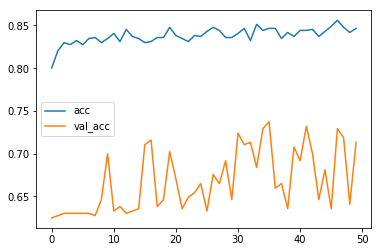

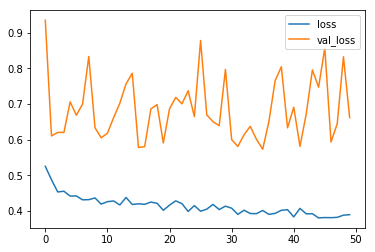

In [30]:
plotnicely(model_history)

Let's predict some images.

In [36]:
files_benign=os.listdir(test_dir+'Benign/')
files_malignant=os.listdir(test_dir+'Malignant')


In [47]:
def predict_image_class(file):
    #load the VGG16 model
    #model = applications.VGG16(include_top=False, weights='imagenet')
    #load the picture
    x = load_img(file, target_size=(img_width,img_height))
    x = img_to_array(x)
    x = np.expand_dims(x, axis=0)
    print(x.shape)
    # process the picture through the first network this will be used as input
    #for the top model
    #array = model.predict(x)
    #build the top model
    #model = Sequential()
    #model.add(Flatten(input_shape=array.shape[1:]))
    #model.add(Dense(256, activation='relu'))
    #model.add(Dropout(0.5))
    #model.add(Dense(1, activation='sigmoid'))
    # and use the weigths trained before
    #model.load_weights(top_model_weights_path)
    class_predicted = model.predict(x)
    if class_predicted==1:
        print("dog")
    else:
        print("cat")

In [48]:
predict_image_class(test_dir+'Benign/'+files_benign[0])

(1, 3, 150, 150)
cat
